## Import Packages

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from scipy.optimize import minimize

from model.environment import envTrader
from utils_file.tools import load_cache_file
from utils_file.finance_tools import *

warnings.filterwarnings("ignore")
path = "figure_file"

## Load Data

In [2]:
static_pt = load_cache_file("data_file/static_strategy/ap_reward_result_test.pkl")

dqn_pt = load_cache_file("pre-train-fixWindow/test_result_119.pkl")
dqn_pt_reward = list(dqn_pt["reward_result"].values())

## Comparison Target: Reduced S&P 500 Constituent

In [3]:
test_data_reduced = pd.read_csv("data_file/test_PT.csv", encoding="UTF-8")
tickers_reduced = test_data_reduced["Ticker"].unique()

In [4]:
# Add daily log return and Bollinger bands to the original stock price data
append_value_reduced = []

for ticker in tickers_reduced:
    target = test_data_reduced[test_data_reduced["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_reduced.append(target)

test_append_reduced = pd.concat(append_value_reduced, ignore_index=True)

In [5]:
# Divide the stock price data of individual stocks according to each month
split_test_reduced = {}

unique_years = test_append_reduced["Year"].unique()
unique_months = test_append_reduced["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test_reduced[f"state_{idx}"] = {}
        mask_table = test_append_reduced[
            (test_append_reduced["Year"] == year)
            & (test_append_reduced["Month"] == month)
        ]

        for ticker in tickers_reduced:
            split_test_reduced[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ].copy()

        idx += 1

### Strategy: Buy and Hold

In [6]:
single_result_reduced_BandH = {}

for state in list(split_test_reduced.keys()):
    all_ticker_reward = []

    for ticker in tickers_reduced:
        all_ticker_reward.append(split_test_reduced[state][ticker]["log_return"].sum())

    single_result_reduced_BandH[state] = all_ticker_reward

In [7]:
single_result_reduced_BandH_table = pd.DataFrame(
    single_result_reduced_BandH, index=tickers_reduced
)

static_pt_table = pd.DataFrame(static_pt).T

### Strategy: Bollinger Bands

In [8]:
# Each component stock executes a Bollinger Band trading strategy
single_result_reduced_BB = {}

for state in list(split_test_reduced.keys()):
    all_ticker_reward = []

    for ticker in tickers_reduced:
        temp = split_test_reduced[state][ticker]

        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward.append(sum(reward_record))

    single_result_reduced_BB[state] = all_ticker_reward

In [9]:
single_result_reduced_BB_table = pd.DataFrame(
    single_result_reduced_BB, index=tickers_reduced
)

### Boxplot for rewards

In [10]:
single_result_reduced_BandH_table.columns = (
    static_pt_table.columns
)  # adjust the column name

plot_data_merge_reduced_BandH = pd.concat(
    [static_pt_table, single_result_reduced_BandH_table], axis=0
)
plot_data_merge_reduced_BandH["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_reduced_BandH_table)

plot_data_merge_reduced_BandH = plot_data_merge_reduced_BandH.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_reduced_BandH["time"] = plot_data_merge_reduced_BandH["time"] + 1

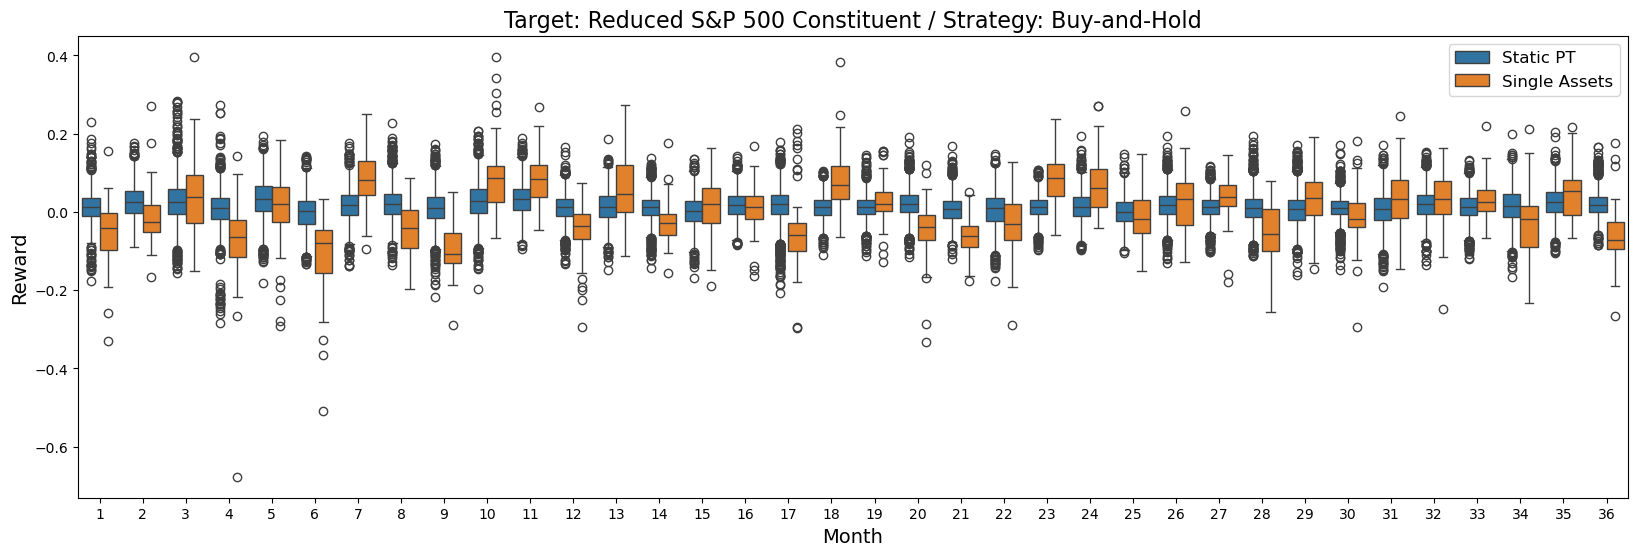

In [11]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_reduced_BandH, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_staticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
single_result_reduced_BB_table.columns = (
    static_pt_table.columns
)  # adjust the column name

plot_data_merge_reduced_BB = pd.concat(
    [static_pt_table, single_result_reduced_BB_table], axis=0
)
plot_data_merge_reduced_BB["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_reduced_BB_table)

plot_data_merge_reduced_BB = plot_data_merge_reduced_BB.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_reduced_BB["time"] = plot_data_merge_reduced_BB["time"] + 1

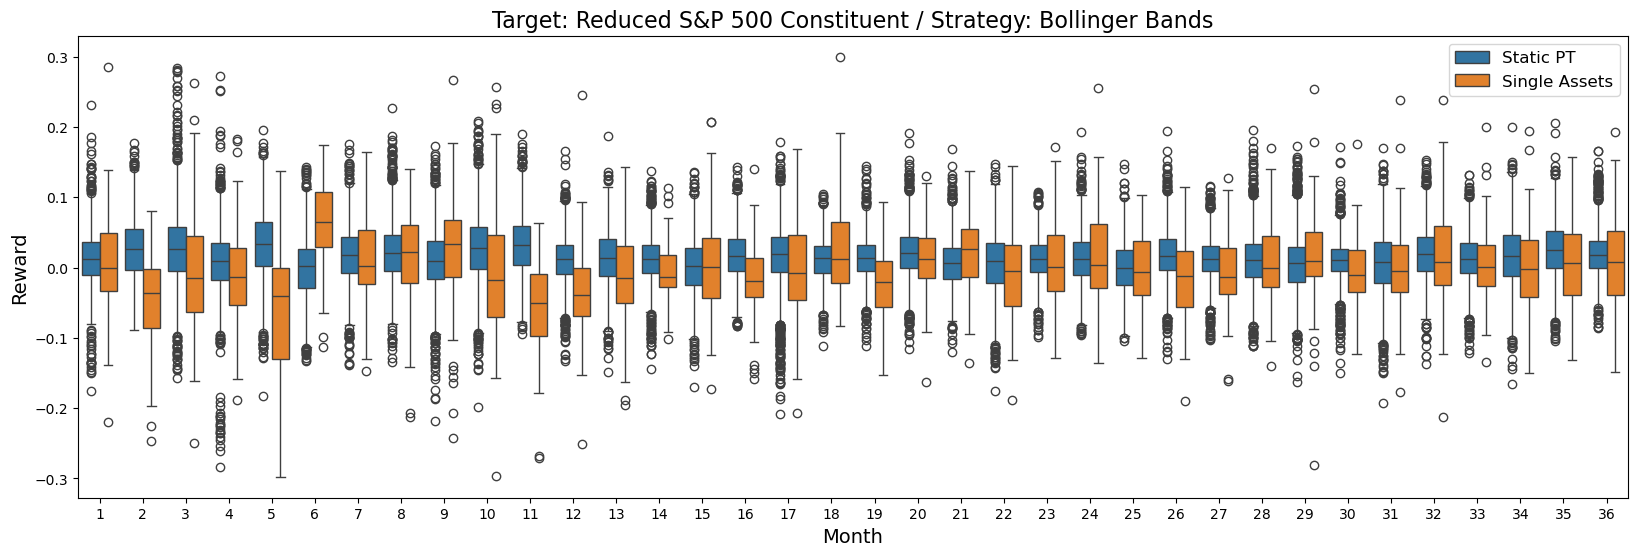

In [13]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_reduced_BB, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title(
    "Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16
)
plt.savefig(f"{path}/reduced_BB_vs_staticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
above_median_x_reduced_BandH, above_median_y_reduced_BandH = [], []
below_median_x_reduced_BandH, below_median_y_reduced_BandH = [], []

for x, y in enumerate(single_result_reduced_BandH_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_reduced_BandH.append(x + 1)
        above_median_y_reduced_BandH.append(value)

    else:
        below_median_x_reduced_BandH.append(x + 1)
        below_median_y_reduced_BandH.append(value)

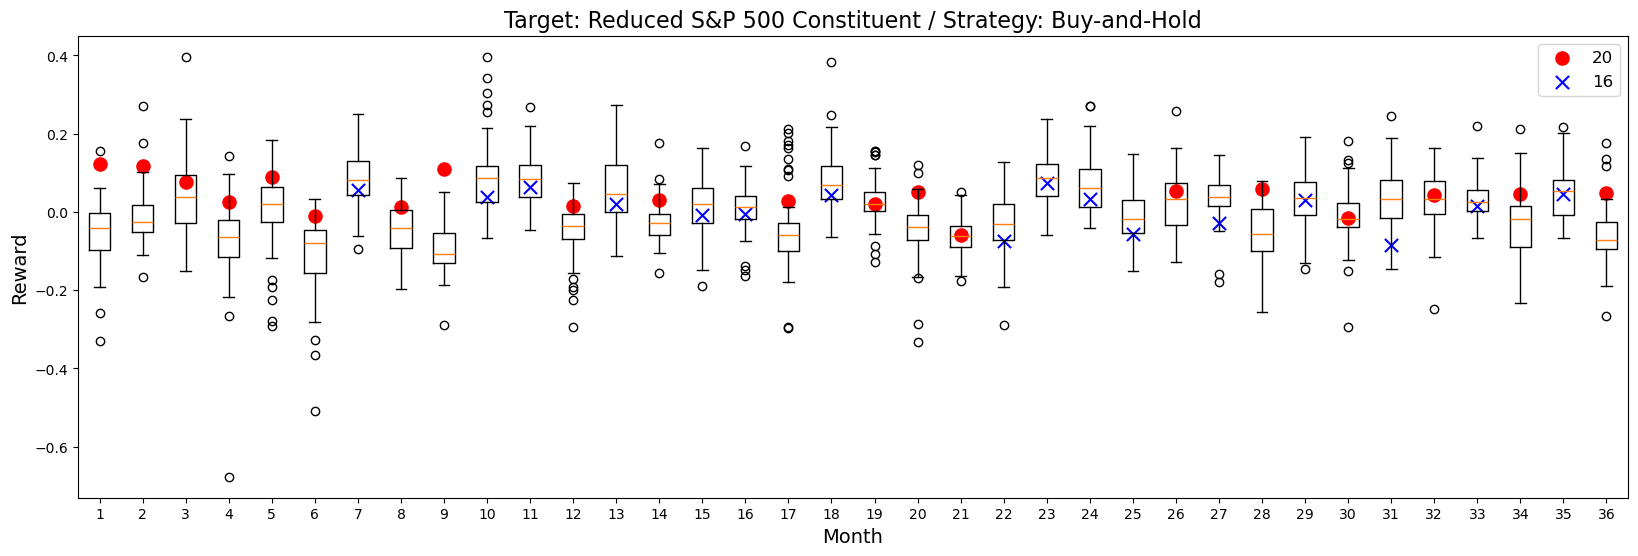

In [15]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_reduced_BandH_table)
plt.scatter(
    above_median_x_reduced_BandH,
    above_median_y_reduced_BandH,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_reduced_BandH)}",
)
plt.scatter(
    below_median_x_reduced_BandH,
    below_median_y_reduced_BandH,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_reduced_BandH)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [16]:
above_median_x_reduced_BB, above_median_y_reduced_BB = [], []
below_median_x_reduced_BB, below_median_y_reduced_BB = [], []

for x, y in enumerate(single_result_reduced_BB_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_reduced_BB.append(x + 1)
        above_median_y_reduced_BB.append(value)

    else:
        below_median_x_reduced_BB.append(x + 1)
        below_median_y_reduced_BB.append(value)

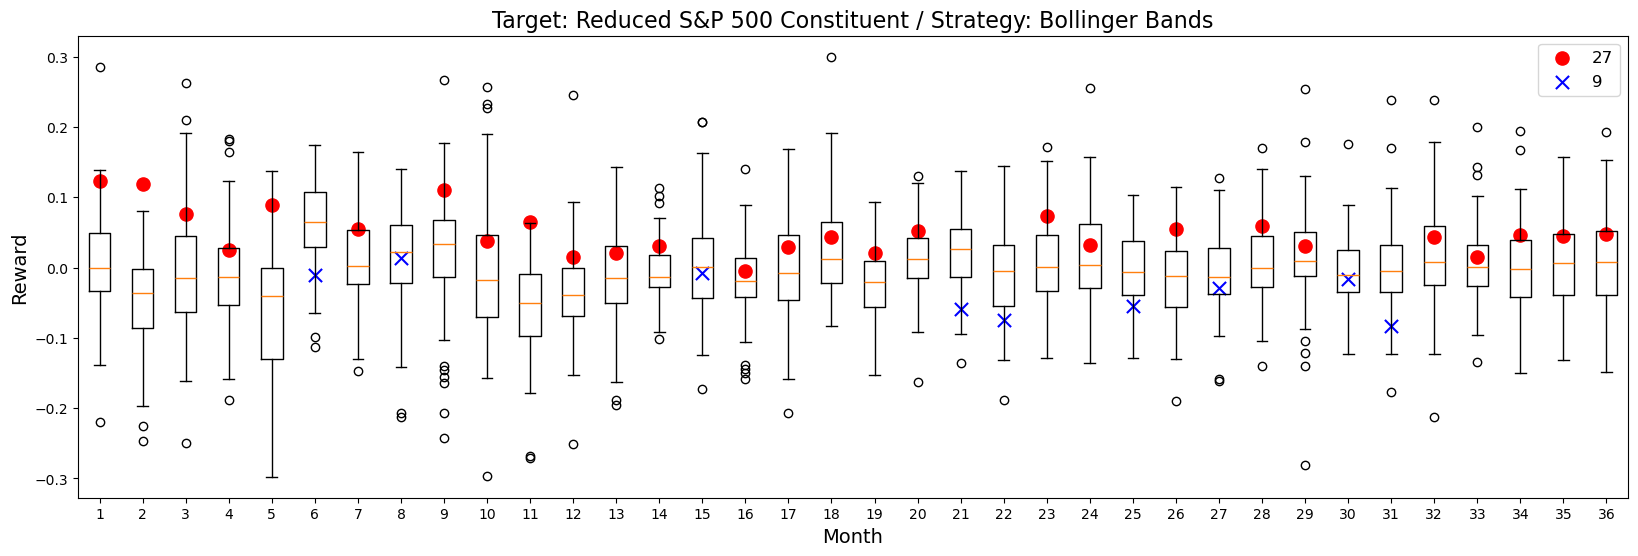

In [17]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_reduced_BB_table)
plt.scatter(
    above_median_x_reduced_BB,
    above_median_y_reduced_BB,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_reduced_BB)}",
)
plt.scatter(
    below_median_x_reduced_BB,
    below_median_y_reduced_BB,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_reduced_BB)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title(
    "Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16
)
plt.savefig(f"{path}/reduced_BB_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

### WRS test for median

In [18]:
static_pt_median = static_pt_table.median(axis=0)
single_median_reduced_BandH = single_result_reduced_BandH_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Reduced S&P 500 (B&H) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Reduced S&P 500 (B&H) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Reduced S&P 500 (B&H) ):  0.0881
p-value of WRS test (DQN-PT vs. Reduced S&P 500 (B&H) ):  0.0457


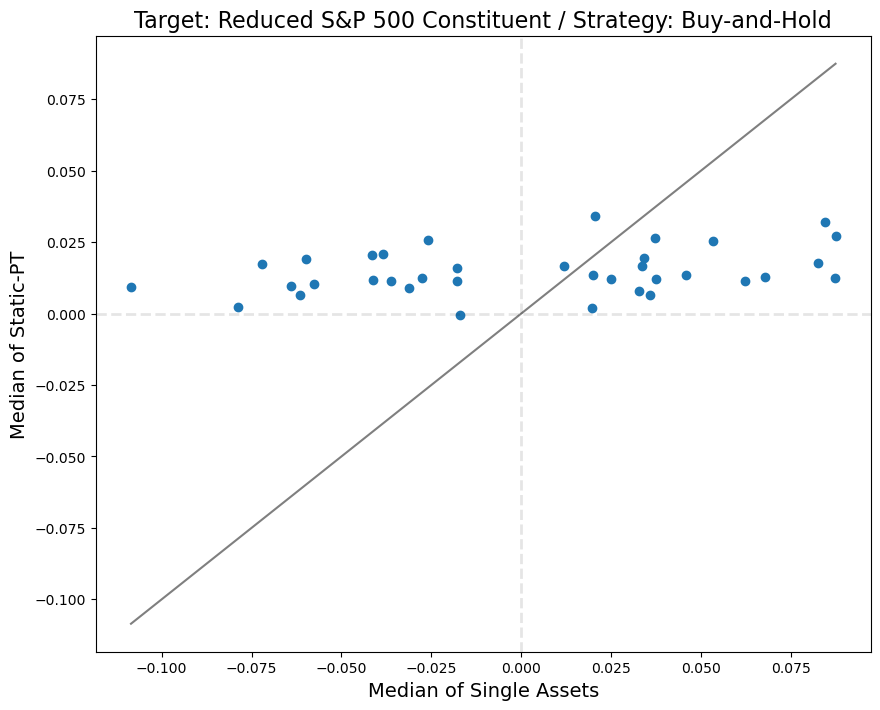

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BandH, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BandH), min(static_pt_median)),
        max(max(single_median_reduced_BandH), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BandH), min(static_pt_median)),
        max(max(single_median_reduced_BandH), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_staticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

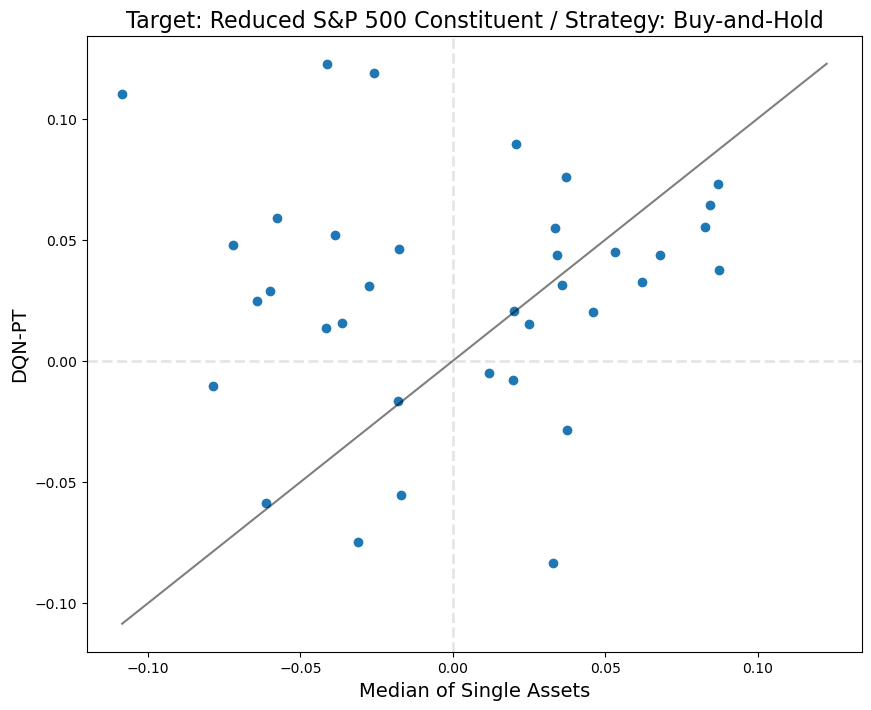

In [20]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BandH), min(dqn_pt_reward)),
        max(max(single_median_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BandH), min(dqn_pt_reward)),
        max(max(single_median_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Reduced S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/reduced_BandH_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

In [21]:
single_median_reduced_BB = single_result_reduced_BB_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_reduced_BB, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Reduced S&P 500 (BB) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_reduced_BB, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Reduced S&P 500 (BB) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Reduced S&P 500 (BB) ):  0.0000
p-value of WRS test (DQN-PT vs. Reduced S&P 500 (BB) ):  0.0013


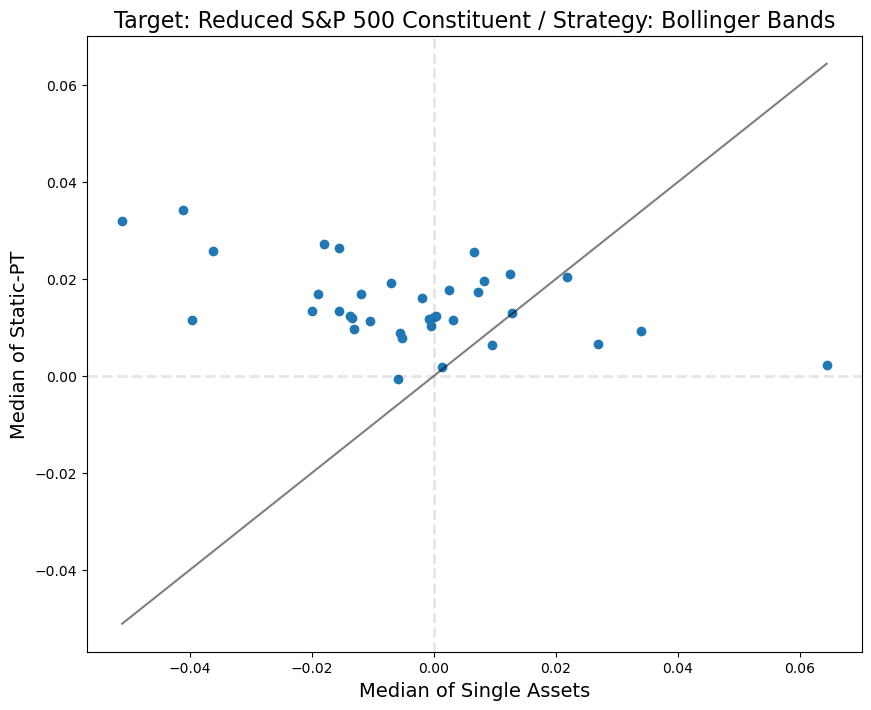

In [22]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BB, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BB), min(static_pt_median)),
        max(max(single_median_reduced_BB), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BB), min(static_pt_median)),
        max(max(single_median_reduced_BB), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title(
    "Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16
)
plt.savefig(f"{path}/reduced_BB_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

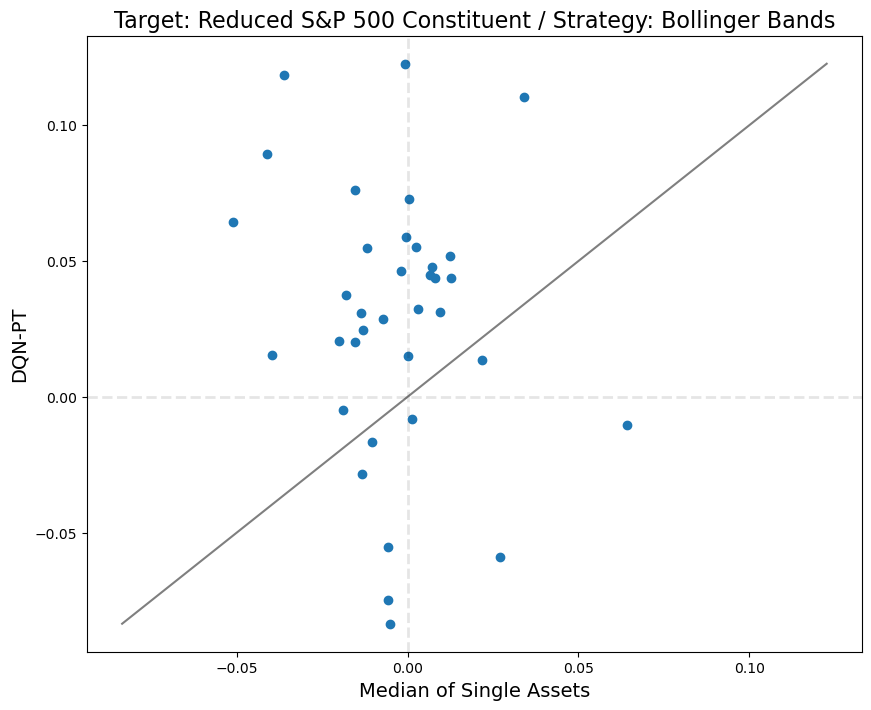

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_reduced_BB, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_reduced_BB), min(dqn_pt_reward)),
        max(max(single_median_reduced_BB), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_reduced_BB), min(dqn_pt_reward)),
        max(max(single_median_reduced_BB), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title(
    "Target: Reduced S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16
)
plt.savefig(f"{path}/reduced_BB_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Total S&P 500 Constituent

In [24]:
test_data_total = pd.read_csv("data_file/test.csv", encoding="UTF-8")
tickers_total = test_data_total["Ticker"].unique()

In [25]:
# Add daily log return and Bollinger bands to the original stock price data
append_value_total = []

for ticker in tickers_total:
    target = test_data_total[test_data_total["Ticker"] == ticker].copy()
    target["ma_line"] = target["Close"].rolling(window=5).mean()
    std = target["Close"].rolling(window=5).std()
    target["upper_bound"] = target["ma_line"] + 1 * std
    target["lower_bound"] = target["ma_line"] - 1 * std

    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_total.append(target)

test_append_total = pd.concat(append_value_total, ignore_index=True)

In [26]:
# Divide the stock price data of individual stocks according to each month
split_test_total = {}

unique_years_total = test_append_total["Year"].unique()
unique_months_total = test_append_total["Month"].unique()

idx = 1
for year in unique_years_total:
    for month in unique_months_total:
        split_test_total[f"state_{idx}"] = {}
        mask_table = test_append_total[
            (test_append_total["Year"] == year) & (test_append_total["Month"] == month)
        ]

        for ticker in tickers_total:
            split_test_total[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ].copy()

        idx += 1

### Strategy: Buy and Hold

In [27]:
single_result_total_BandH = {}

for state in list(split_test_total.keys()):
    all_ticker_reward_total = []

    for ticker in tickers_total:
        all_ticker_reward_total.append(
            split_test_total[state][ticker]["log_return"].sum()
        )

    single_result_total_BandH[state] = all_ticker_reward_total

In [28]:
single_result_total_BandH_table = pd.DataFrame(
    single_result_total_BandH, index=tickers_total
)

### Strategy: Bollinger Bands

In [29]:
# Each component stock executes a Bollinger Band trading strategy
single_result_total_BB = {}

for state in list(split_test_total.keys()):
    all_ticker_reward_total = []

    for ticker in tickers_total:
        temp = split_test_total[state][ticker]

        ub_open_flag = False
        lb_open_flag = False
        status_list = []

        for i, row in temp.iterrows():
            if row["Close"] > row["upper_bound"] and ub_open_flag is False:
                status_list.append("UB_open")
                ub_open_flag = True

            elif row["Close"] < row["ma_line"] and ub_open_flag is True:
                status_list.append("UB_close")
                ub_open_flag = False

            elif row["Close"] < row["lower_bound"] and lb_open_flag is False:
                status_list.append("LB_open")
                lb_open_flag = True

            elif row["Close"] > row["ma_line"] and lb_open_flag is True:
                status_list.append("LB_close")
                lb_open_flag = False

            else:
                status_list.append(0)

        status_list[-1] = "close"
        temp["status"] = status_list

        reward_record = []
        UB_price = None
        LB_price = None

        for i, row in temp.iterrows():
            if row["status"] == "UB_open" and UB_price is None:
                UB_price = row["Close"]

            elif row["status"] == "LB_open" and LB_price is None:
                LB_price = row["Close"]

            elif row["status"] == "UB_close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)
                UB_price = None

            elif row["status"] == "LB_close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)
                LB_price = None

            elif row["status"] == "close" and UB_price is not None:
                simple_return = (row["Close"] - UB_price) / UB_price
                reward_record.append(simple_return)

            elif row["status"] == "close" and LB_price is not None:
                simple_return = -(row["Close"] - LB_price) / LB_price
                reward_record.append(simple_return)

        all_ticker_reward_total.append(sum(reward_record))

    single_result_total_BB[state] = all_ticker_reward_total

In [30]:
single_result_total_BB_table = pd.DataFrame(single_result_total_BB, index=tickers_total)

In [31]:
single_result_total_BandH_table.columns = (
    static_pt_table.columns
)  # adjust the column name

plot_data_merge_total_BandH = pd.concat(
    [static_pt_table, single_result_total_BandH_table], axis=0
)
plot_data_merge_total_BandH["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_total_BandH_table)

plot_data_merge_total_BandH = plot_data_merge_total_BandH.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_total_BandH["time"] = plot_data_merge_total_BandH["time"] + 1

### Boxplot for rewards

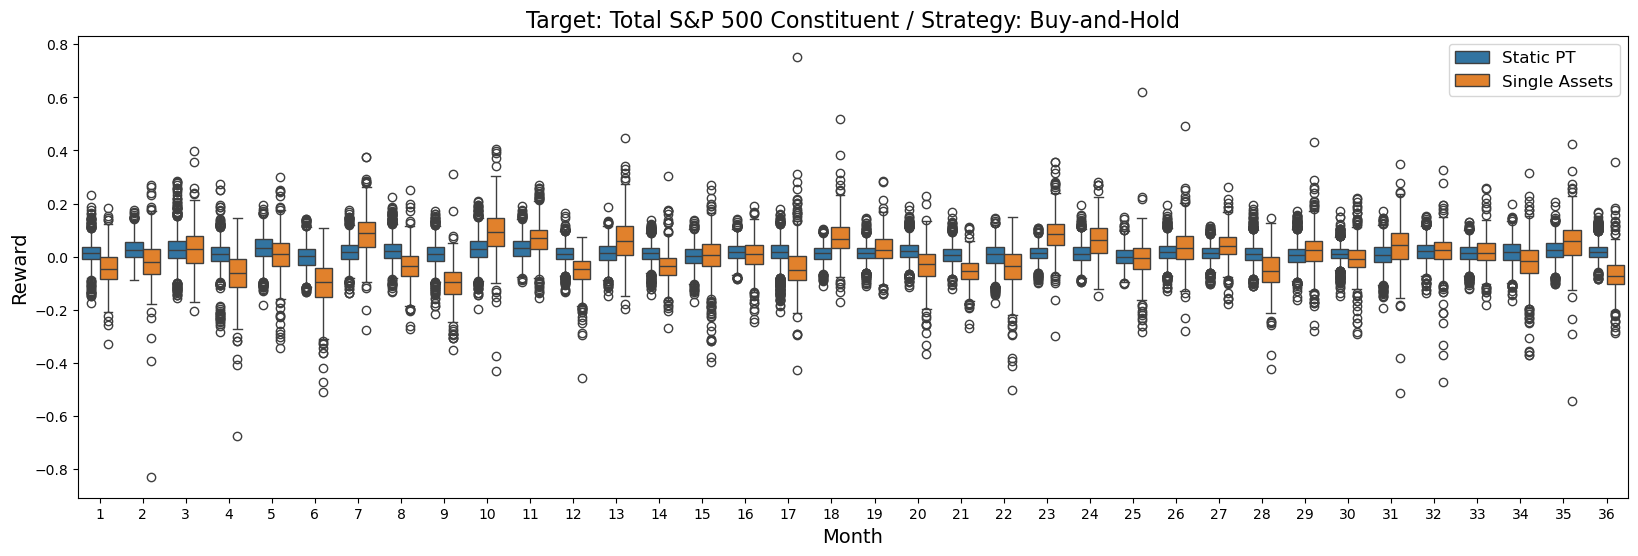

In [32]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_total_BandH, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_StaticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [33]:
single_result_total_BB_table.columns = static_pt_table.columns  # adjust the column name

plot_data_merge_total_BB = pd.concat(
    [static_pt_table, single_result_total_BB_table], axis=0
)
plot_data_merge_total_BB["type"] = ["Static PT"] * len(static_pt_table) + [
    "Single Assets"
] * len(single_result_total_BB_table)

plot_data_merge_total_BB = plot_data_merge_total_BB.melt(
    id_vars="type", var_name="time", value_name="value"
)
plot_data_merge_total_BB["time"] = plot_data_merge_total_BB["time"] + 1

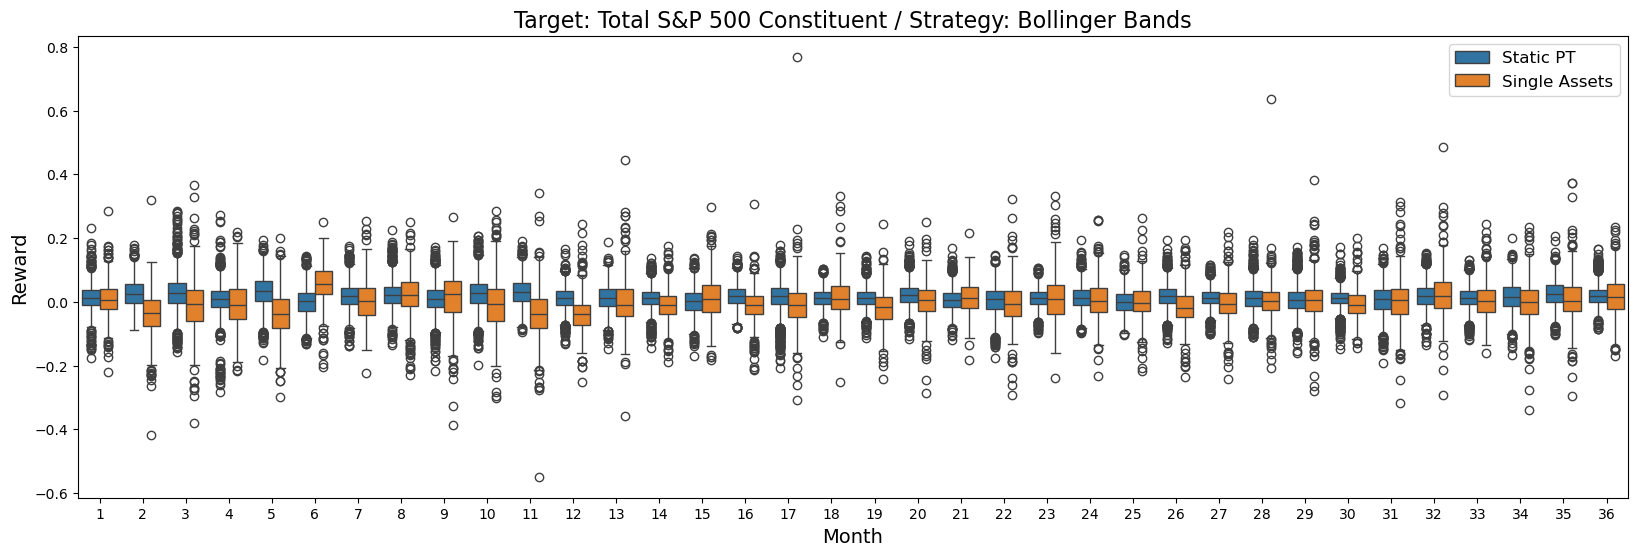

In [34]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=plot_data_merge_total_BB, x="time", y="value", hue="type")
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_StaticPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [35]:
above_median_x_total_BandH, above_median_y_total_BandH = [], []
below_median_x_total_BandH, below_median_y_total_BandH = [], []

for x, y in enumerate(single_result_total_BandH_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_total_BandH.append(x + 1)
        above_median_y_total_BandH.append(value)

    else:
        below_median_x_total_BandH.append(x + 1)
        below_median_y_total_BandH.append(value)

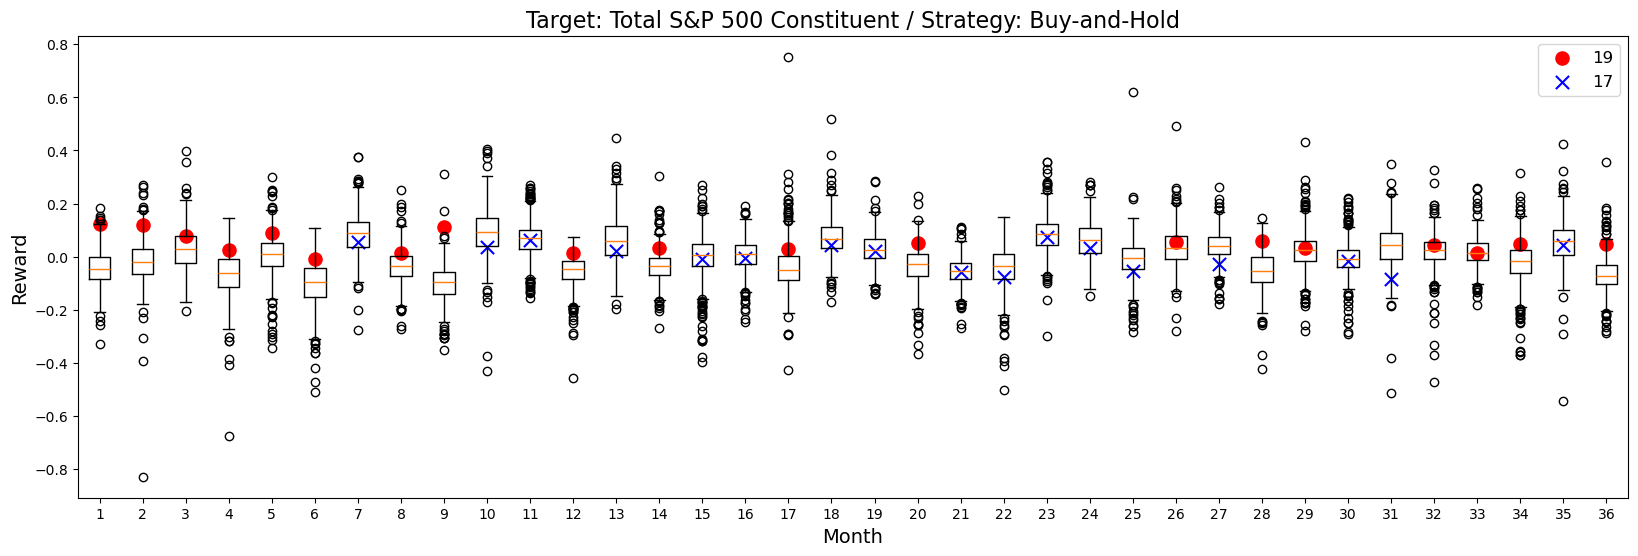

In [36]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_total_BandH_table)
plt.scatter(
    above_median_x_total_BandH,
    above_median_y_total_BandH,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_total_BandH)}",
)
plt.scatter(
    below_median_x_total_BandH,
    below_median_y_total_BandH,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_total_BandH)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

In [37]:
above_median_x_BB_total, above_median_y_BB_total = [], []
below_median_x_BB_total, below_median_y_BB_total = [], []

for x, y in enumerate(single_result_total_BB_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_BB_total.append(x + 1)
        above_median_y_BB_total.append(value)

    else:
        below_median_x_BB_total.append(x + 1)
        below_median_y_BB_total.append(value)

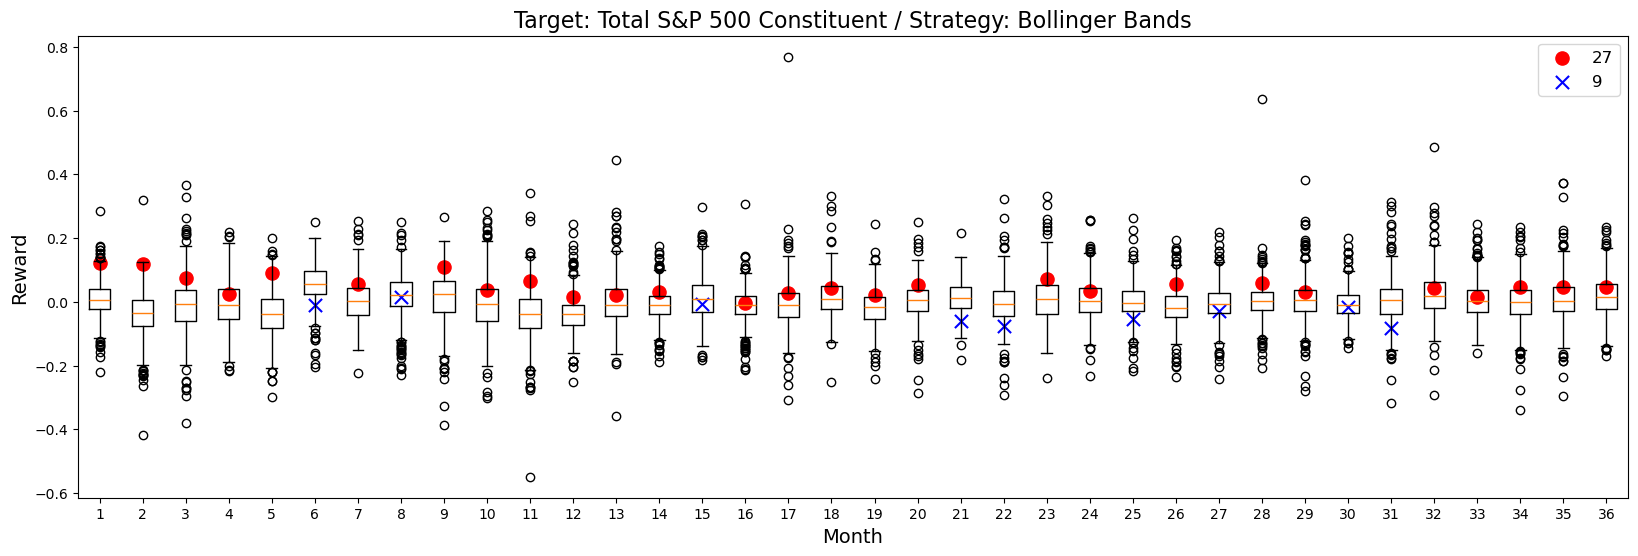

In [38]:
plt.figure(figsize=(20, 6))
plt.boxplot(single_result_total_BB_table)
plt.scatter(
    above_median_x_BB_total,
    above_median_y_BB_total,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_BB_total)}",
)
plt.scatter(
    below_median_x_BB_total,
    below_median_y_BB_total,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_BB_total)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

### WRS test for median

In [39]:
static_pt_median = static_pt_table.median(axis=0)
single_median_total_BandH = single_result_total_BandH_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_total_BandH, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Total S&P 500 (B&H) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_total_BandH, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Total S&P 500 (B&H) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Total S&P 500 (B&H) ):  0.0907
p-value of WRS test (DQN-PT vs. Total S&P 500 (B&H) ):  0.0427


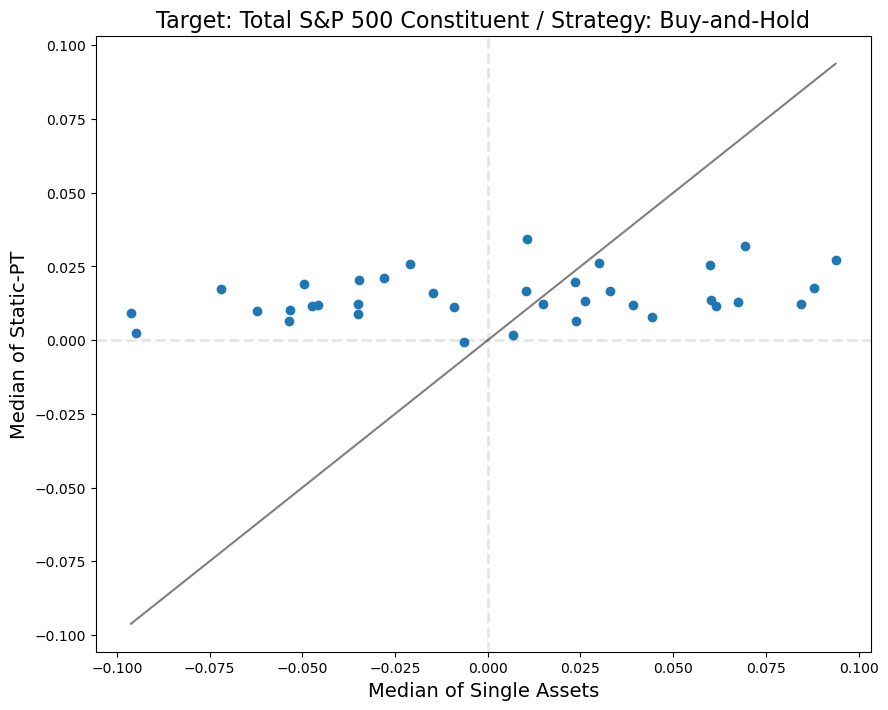

In [40]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BandH, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_total_BandH), min(static_pt_median)),
        max(max(single_median_total_BandH), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BandH), min(static_pt_median)),
        max(max(single_median_total_BandH), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

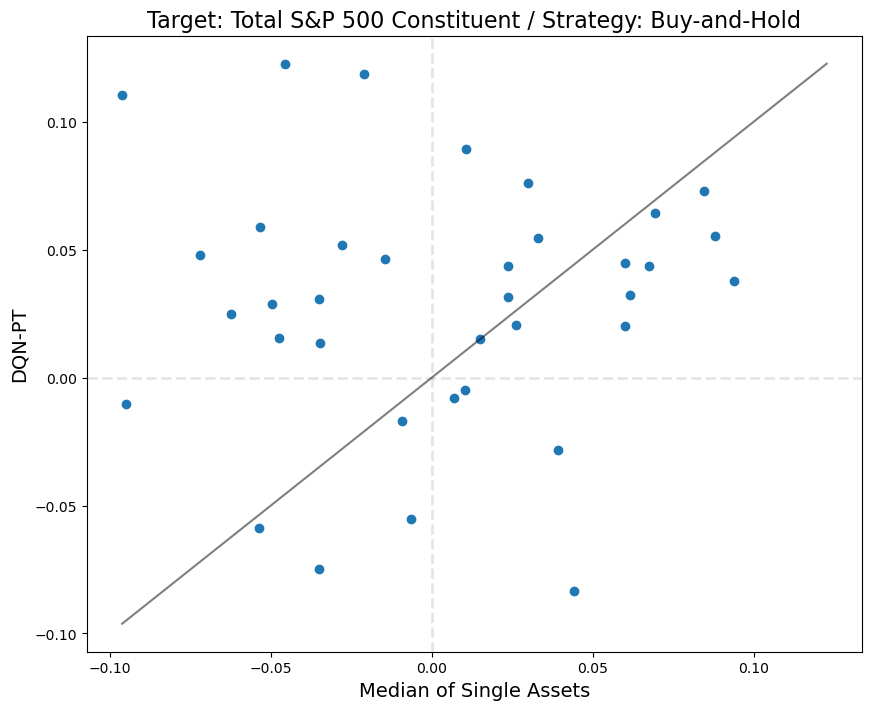

In [41]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_total_BandH), min(dqn_pt_reward)),
        max(max(single_median_total_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BandH), min(dqn_pt_reward)),
        max(max(single_median_total_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Buy-and-Hold", fontsize=16)
plt.savefig(f"{path}/total_BandH_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

In [42]:
single_median_total_BB = single_result_total_BB_table.median(axis=0)

statistic, pvalue = wilcoxon(
    static_pt_median, single_median_total_BB, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Total S&P 500 (BB) ): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, single_median_total_BB, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Total S&P 500 (BB) ): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Total S&P 500 (BB) ):  0.0000
p-value of WRS test (DQN-PT vs. Total S&P 500 (BB) ):  0.0017


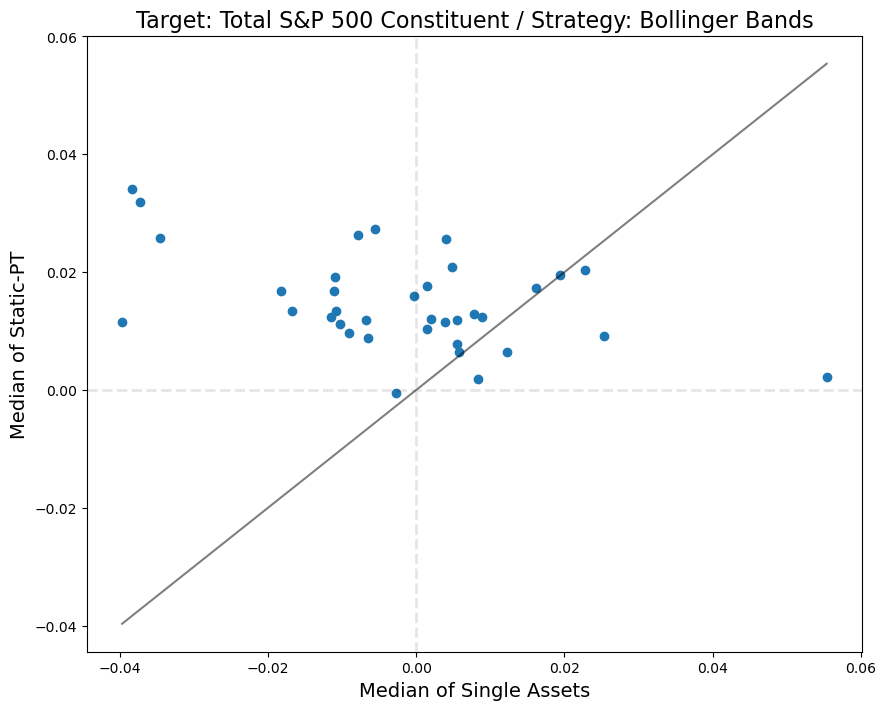

In [43]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BB, static_pt_median)
plt.plot(
    np.linspace(
        min(min(single_median_total_BB), min(static_pt_median)),
        max(max(single_median_total_BB), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BB), min(static_pt_median)),
        max(max(single_median_total_BB), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("Median of Static-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

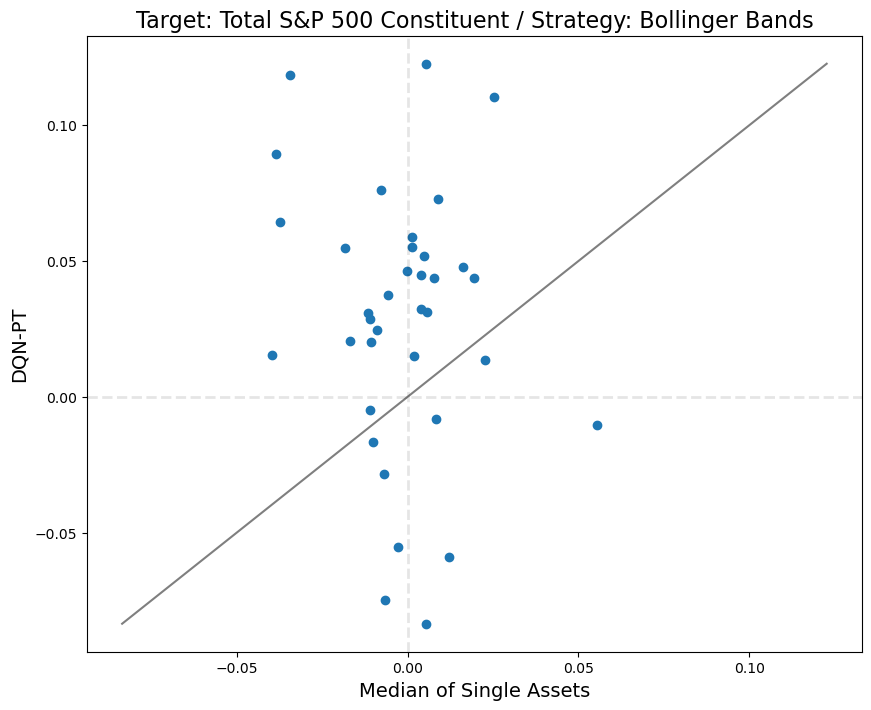

In [44]:
plt.figure(figsize=(10, 8))
plt.scatter(single_median_total_BB, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(single_median_total_BB), min(dqn_pt_reward)),
        max(max(single_median_total_BB), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(single_median_total_BB), min(dqn_pt_reward)),
        max(max(single_median_total_BB), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Single Assets", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Total S&P 500 Constituent / Strategy: Bollinger Bands", fontsize=16)
plt.savefig(f"{path}/total_BB_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Static Pairs Trading

### Boxplot for rewards

In [45]:
above_median_x_pt, above_median_y_pt = [], []
below_median_x_pt, below_median_y_pt = [], []

for x, y in enumerate(static_pt_table.median()):
    value = dqn_pt_reward[x]

    if value > y:
        above_median_x_pt.append(x + 1)
        above_median_y_pt.append(value)

    else:
        below_median_x_pt.append(x + 1)
        below_median_y_pt.append(value)

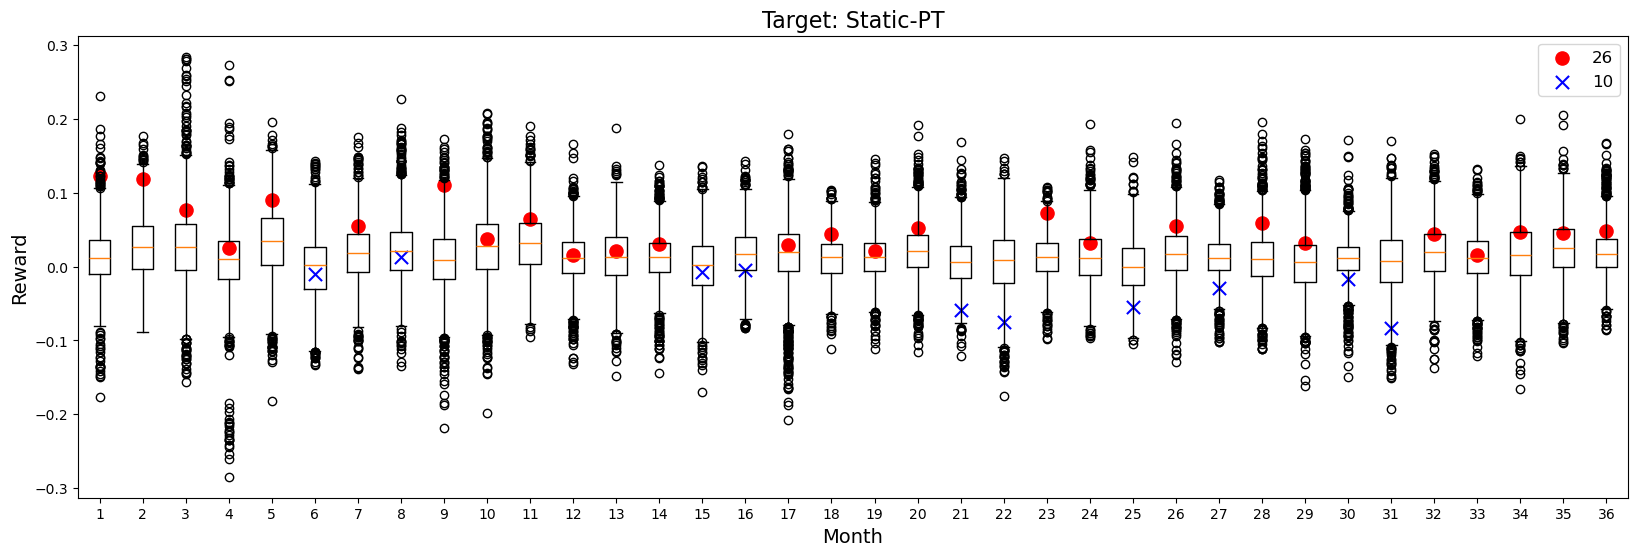

In [46]:
plt.figure(figsize=(20, 6))
plt.boxplot(static_pt_table)
plt.scatter(
    above_median_x_pt,
    above_median_y_pt,
    s=90,
    color="red",
    marker="o",
    label=f"{len(above_median_x_pt)}",
)
plt.scatter(
    below_median_x_pt,
    below_median_y_pt,
    s=90,
    color="blue",
    marker="x",
    label=f"{len(below_median_x_pt)}",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=12)
plt.title("Target: Static-PT", fontsize=16)
plt.savefig(f"{path}/StaticPT_vs_DQNPT.png", dpi=300, bbox_inches="tight")
plt.show()

### WRS test for median

In [47]:
statistic, pvalue = wilcoxon(dqn_pt_reward, static_pt_median, alternative="greater")
print(f"p-value of WRS test: {pvalue: .4f}")

p-value of WRS test:  0.0174


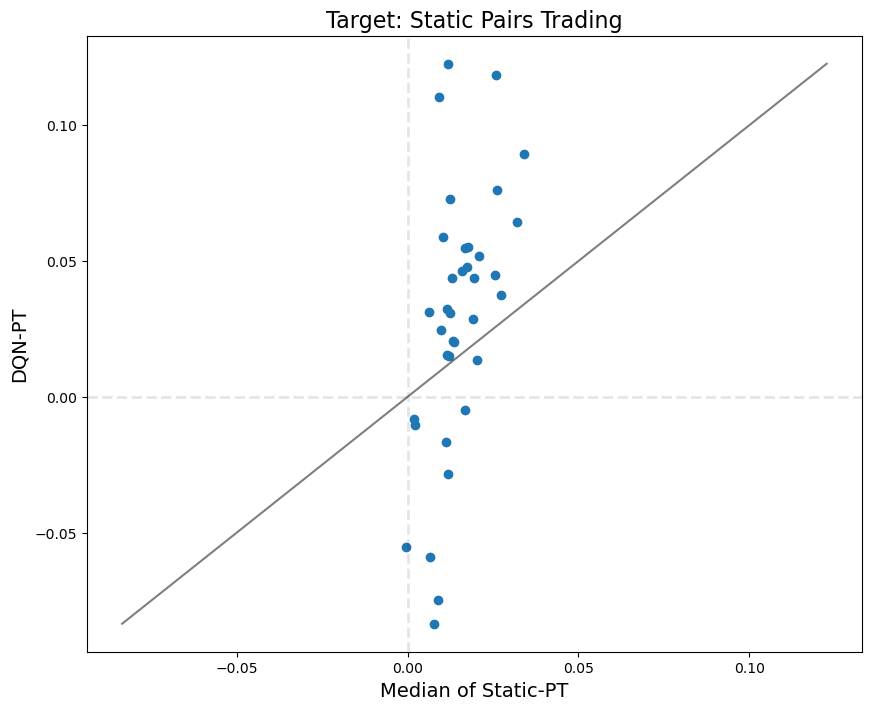

In [48]:
plt.figure(figsize=(10, 8))
plt.scatter(static_pt_median, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(static_pt_median), min(dqn_pt_reward)),
        max(max(static_pt_median), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(static_pt_median), min(dqn_pt_reward)),
        max(max(static_pt_median), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Median of Static-PT", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Static Pairs Trading", fontsize=16)
plt.savefig(f"{path}/StaticPT_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Tangency Portfolio from Reduced S&P 500 Constituent

In [49]:
train_data_reduced = pd.read_csv("data_file/train_PT.csv", encoding="UTF-8")
tickers_reduced = train_data_reduced["Ticker"].unique()

In [50]:
train_reduced_table = {}

for ticker in tickers_reduced:
    target = train_data_reduced[train_data_reduced["Ticker"] == ticker].copy()
    temp_result = np.log(target["Close"] / target["Close"].shift(1))
    train_reduced_table[ticker] = temp_result.dropna().values

train_reduced_table = pd.DataFrame(train_reduced_table)
train_reduced_table_mu = train_reduced_table.mean().values
train_reduced_table_cov = train_reduced_table.cov().values

In [51]:
def neg_sharpe_ratio(weights, mu, cov):
    portfolio_return = np.dot(weights, mu)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))

    return -portfolio_return / portfolio_volatility


def tangency_portfolio(mu, cov):
    num_assets = len(mu)
    initial_weights = np.ones(num_assets) / num_assets
    # bounds = [(-np.inf, np.inf) for _ in range(num_assets)]
    bounds = [(0, 1) for _ in range(num_assets)]
    constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
    result = minimize(
        neg_sharpe_ratio,
        initial_weights,
        args=(mu, cov),
        method="SLSQP",
        bounds=bounds,
        constraints=constraints,
    )

    return result.x

In [52]:
test_append_reduced_table = pd.DataFrame(
    {
        ticker: test_append_reduced[test_append_reduced["Ticker"] == ticker][
            "log_return"
        ].values
        for ticker in tickers_reduced
    }
)

test_append_reduced_returns = [
    np.dot(
        tangency_portfolio(train_reduced_table_mu, train_reduced_table_cov),
        test_append_reduced_table.iloc[x, :].values,
    )
    for x in range(test_append_reduced_table.shape[0])
]

In [53]:
temp = test_append_reduced[test_append_reduced["Ticker"] == tickers_reduced[0]]
temp["weighted_logrtn"] = test_append_reduced_returns

portfolio_result_reduced_BandH = []

for year in temp["Year"].unique():
    for month in temp["Month"].unique():
        mask_table = temp[(temp["Year"] == year) & (temp["Month"] == month)]
        portfolio_result_reduced_BandH.append(mask_table["weighted_logrtn"].sum())

### WRS test

In [54]:
statistic, pvalue = wilcoxon(
    static_pt_median, portfolio_result_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Reduced Portfolio): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, portfolio_result_reduced_BandH, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Reduced Portfolio): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Reduced Portfolio):  0.1291
p-value of WRS test (DQN-PT vs. Reduced Portfolio):  0.0739


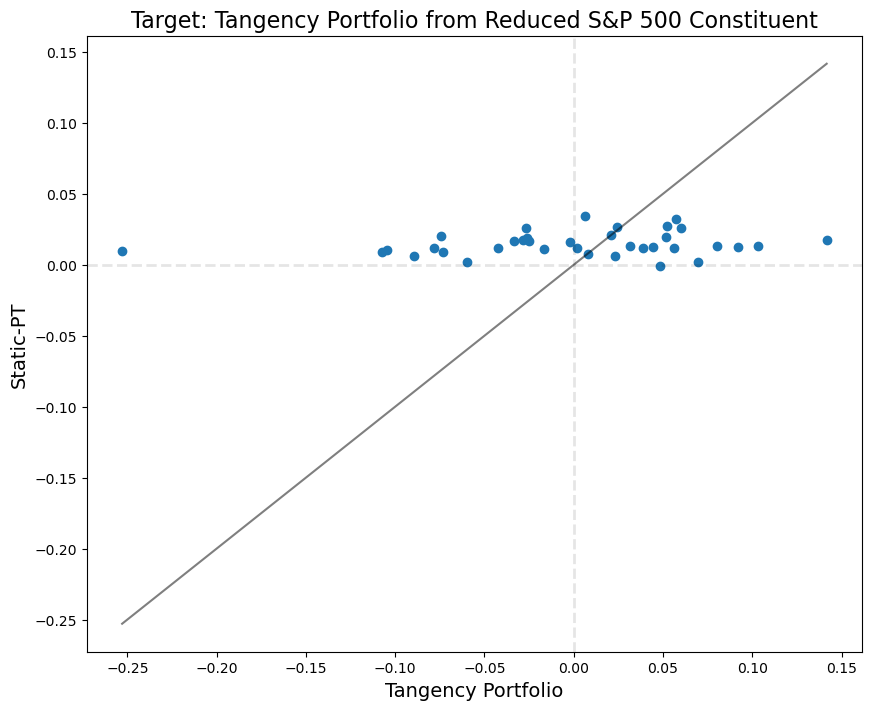

In [55]:
plt.figure(figsize=(10, 8))
plt.scatter(portfolio_result_reduced_BandH, static_pt_median)
plt.plot(
    np.linspace(
        min(min(portfolio_result_reduced_BandH), min(static_pt_median)),
        max(max(portfolio_result_reduced_BandH), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(portfolio_result_reduced_BandH), min(static_pt_median)),
        max(max(portfolio_result_reduced_BandH), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("Static-PT", fontsize=14)
plt.title("Target: Tangency Portfolio from Reduced S&P 500 Constituent", fontsize=16)
plt.savefig(f"{path}/port_reduced_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

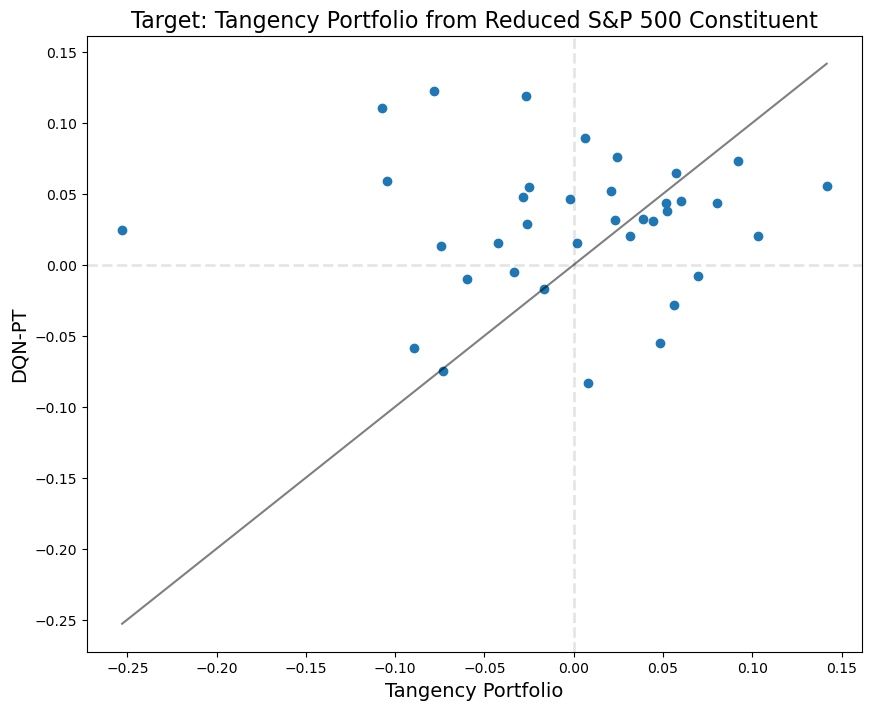

In [56]:
plt.figure(figsize=(10, 8))
plt.scatter(portfolio_result_reduced_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(portfolio_result_reduced_BandH), min(dqn_pt_reward)),
        max(max(portfolio_result_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(portfolio_result_reduced_BandH), min(dqn_pt_reward)),
        max(max(portfolio_result_reduced_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Tangency Portfolio from Reduced S&P 500 Constituent", fontsize=16)
plt.savefig(f"{path}/port_reduced_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Tangency Portfolio from Total S&P 500 Constituent

In [57]:
train_data_total = pd.read_csv("data_file/train.csv", encoding="UTF-8")
tickers_total = train_data_total["Ticker"].unique()

In [58]:
train_total_table = {}

for ticker in tickers_total:
    target = train_data_total[train_data_total["Ticker"] == ticker].copy()
    temp_result = np.log(target["Close"] / target["Close"].shift(1))
    train_total_table[ticker] = temp_result.dropna().values

train_total_table = pd.DataFrame(train_total_table)
train_total_table_mu = train_total_table.mean().values
train_total_table_cov = train_total_table.cov().values

In [59]:
# test_append_total_table = pd.DataFrame(
#     {
#         ticker: test_append_total[test_append_total["Ticker"] == ticker]["log_return"].values
#         for ticker in tickers_total
#     }
# )

# test_append_total_returns = [
#     np.dot(
#         tangency_portfolio(train_total_table_mu, train_total_table_cov),
#         test_append_total_table.iloc[x, :].values,
#     )
#     for x in range(test_append_total_table.shape[0])
# ]

test_append_total_returns = load_cache_file("data_file/test_append_total_returns.pkl")

In [60]:
temp = test_append_total[test_append_total["Ticker"] == tickers_total[0]]
temp["weighted_logrtn"] = test_append_total_returns

portfolio_result_total_BandH = []

for year in temp["Year"].unique():
    for month in temp["Month"].unique():
        mask_table = temp[(temp["Year"] == year) & (temp["Month"] == month)]
        portfolio_result_total_BandH.append(mask_table["weighted_logrtn"].sum())

### WRS test

In [61]:
statistic, pvalue = wilcoxon(
    static_pt_median, portfolio_result_total_BandH, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Total Portfolio): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(
    dqn_pt_reward, portfolio_result_total_BandH, alternative="greater"
)
print(f"p-value of WRS test (DQN-PT vs. Total Portfolio): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Total Portfolio):  0.2070
p-value of WRS test (DQN-PT vs. Total Portfolio):  0.0633


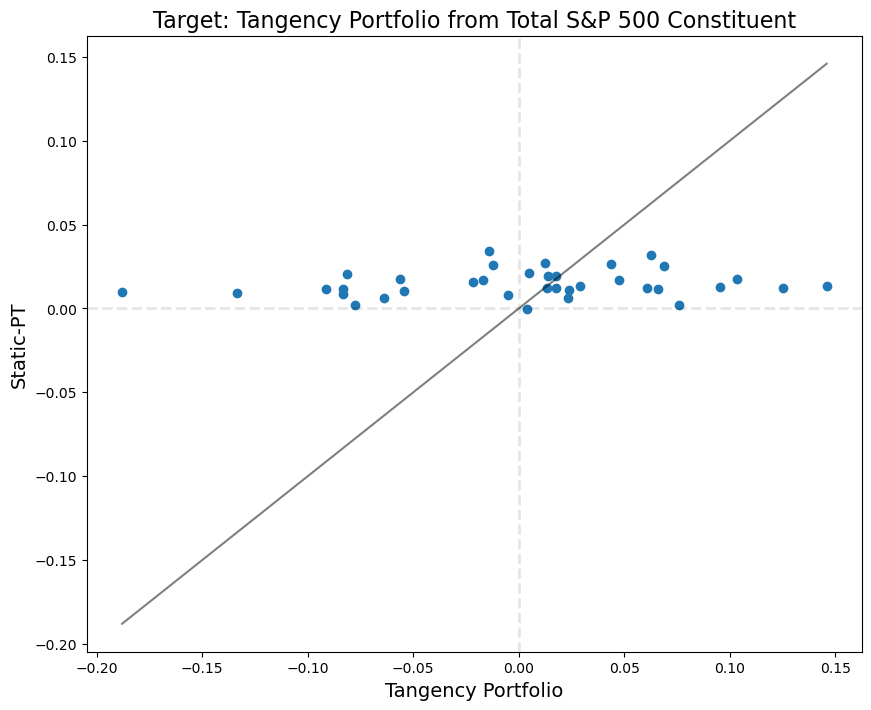

In [62]:
plt.figure(figsize=(10, 8))
plt.scatter(portfolio_result_total_BandH, static_pt_median)
plt.plot(
    np.linspace(
        min(min(portfolio_result_total_BandH), min(static_pt_median)),
        max(max(portfolio_result_total_BandH), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(portfolio_result_total_BandH), min(static_pt_median)),
        max(max(portfolio_result_total_BandH), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("Static-PT", fontsize=14)
plt.title("Target: Tangency Portfolio from Total S&P 500 Constituent", fontsize=16)
plt.savefig(f"{path}/port_total_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

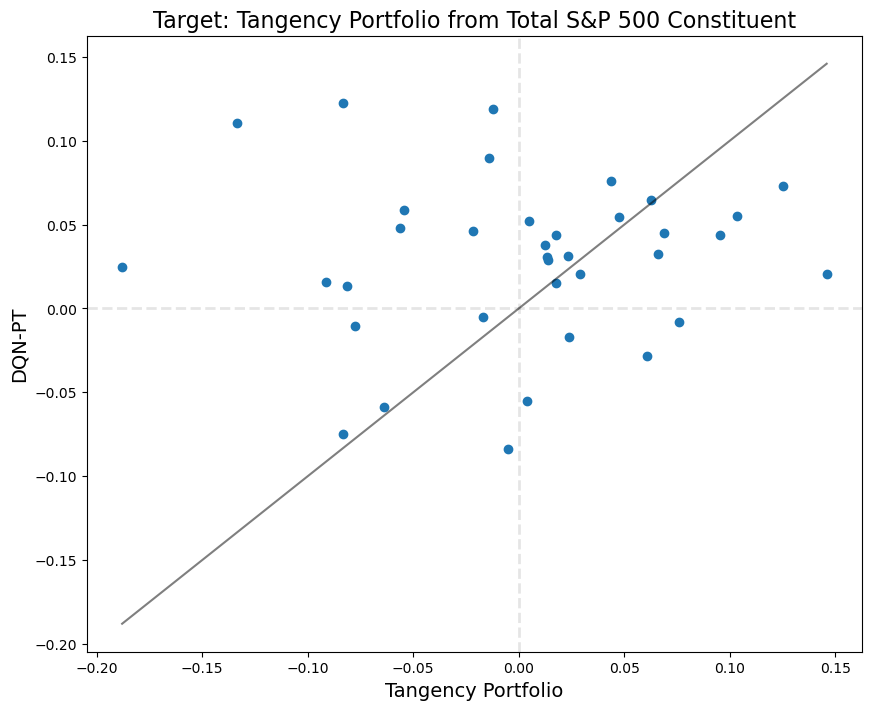

In [63]:
plt.figure(figsize=(10, 8))
plt.scatter(portfolio_result_total_BandH, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(portfolio_result_total_BandH), min(dqn_pt_reward)),
        max(max(portfolio_result_total_BandH), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(portfolio_result_total_BandH), min(dqn_pt_reward)),
        max(max(portfolio_result_total_BandH), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Tangency Portfolio from Total S&P 500 Constituent", fontsize=16)
plt.savefig(f"{path}/port_total_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Comparison Target: Han et al. (2023)

In [64]:
inital_month_paper = train_data_reduced[
    (train_data_reduced["Year"] == 2021) & (train_data_reduced["Month"] == 12)
]

In [65]:
# Add daily log return and Bollinger bands to the original stock price data
append_value_paper = []

for ticker in tickers_reduced:
    target = inital_month_paper[inital_month_paper["Ticker"] == ticker].copy()
    target["log_return"] = np.log(target["Close"] / target["Close"].shift(1))

    target = target.dropna()
    append_value_paper.append(target)

inital_month_paper = pd.concat(append_value_paper, ignore_index=True)

In [66]:
# Divide the stock price data of individual stocks according to each month
split_test_paper = {}

unique_years = inital_month_paper["Year"].unique()
unique_months = inital_month_paper["Month"].unique()

idx = 1
for year in unique_years:
    for month in unique_months:
        split_test_paper[f"state_{idx}"] = {}
        mask_table = inital_month_paper[
            (inital_month_paper["Year"] == year)
            & (inital_month_paper["Month"] == month)
        ]

        for ticker in tickers_reduced:
            split_test_paper[f"state_{idx}"][ticker] = mask_table[
                mask_table["Ticker"] == ticker
            ].copy()

        idx += 1

In [67]:
mom_1_paper = {}

for state in list(split_test_paper.keys()):
    all_ticker_reward = []

    for ticker in tickers_reduced:
        all_ticker_reward.append(split_test_paper[state][ticker]["log_return"].sum())

    mom_1_paper[state] = all_ticker_reward

mom_1_paper = pd.DataFrame(mom_1_paper, index=tickers_reduced)
mom_1_paper_BandH_table = single_result_reduced_BandH_table.copy()
mom_1_paper_BandH_table.insert(
    loc=0, column="init", value=mom_1_paper["state_1"].values
)

In [87]:
mom_1_pair_list = []

for colname in mom_1_paper_BandH_table.columns:
    mom_1_pair_list_index = (
        mom_1_paper_BandH_table[colname].sort_values(ascending=False).index
    )
    mom_1_pair_list.append(f"{mom_1_pair_list_index[0]}-{mom_1_pair_list_index[-1]}")

del mom_1_pair_list[-1]

In [88]:
for i in range(len(mom_1_pair_list)):
    target_alphabet = mom_1_pair_list[i].split("-")
    if target_alphabet[0] > target_alphabet[1]:
        mom_1_pair_list[i] = f"{target_alphabet[1]}-{target_alphabet[0]}"

In [91]:
state_space_trading = load_cache_file(
    "data_file/env_dqn_space/state_space_trading_test.pkl"
)
state_space_merge = load_cache_file(
    "data_file/env_dqn_space/state_space_merge_test.pkl"
)
coint_coef = load_cache_file("data_file/env_dqn_space/coint_coef_test.pkl")
action_space = [k for k in state_space_trading["state_1"].keys()]

In [92]:
env = envTrader(
    trade_state_space=state_space_trading,
    agent_state_space=state_space_merge,
    coint_coef_space=coint_coef,
    action_space=action_space,
)

In [98]:
state = env.reset()
done = False
paper_reward_result = []
paper_cum_reward_result = []

while not done:
    for pair in mom_1_pair_list:
        action = pair
    next_state, reward, cum_reward, done = env.step(action)

    state = next_state

    paper_reward_result.append(reward)
    paper_cum_reward_result.append(cum_reward)

### WRS test

In [99]:
statistic, pvalue = wilcoxon(
    static_pt_median, paper_reward_result, alternative="greater"
)
print(f"p-value of WRS test (Static-PT vs. Han et al.): {pvalue: .4f}")

print("=" * 30)

statistic, pvalue = wilcoxon(dqn_pt_reward, paper_reward_result, alternative="greater")
print(f"p-value of WRS test (DQN-PT vs. Han et al.): {pvalue: .4f}")

p-value of WRS test (Static-PT vs. Han et al.):  0.2960
p-value of WRS test (DQN-PT vs. Han et al.):  0.1015


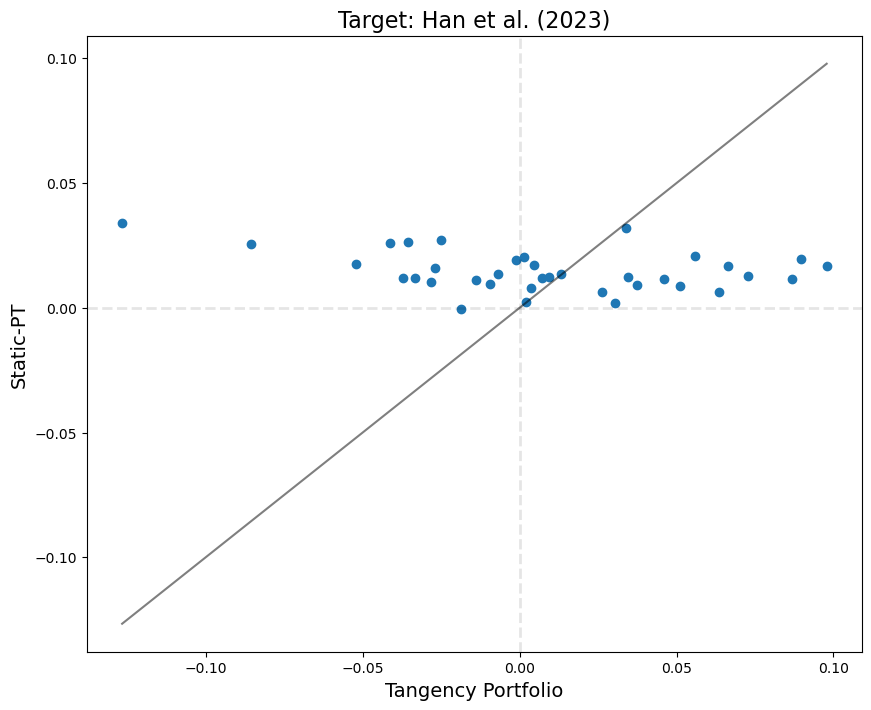

In [100]:
plt.figure(figsize=(10, 8))
plt.scatter(paper_reward_result, static_pt_median)
plt.plot(
    np.linspace(
        min(min(paper_reward_result), min(static_pt_median)),
        max(max(paper_reward_result), max(static_pt_median)),
        200,
    ),
    np.linspace(
        min(min(paper_reward_result), min(static_pt_median)),
        max(max(paper_reward_result), max(static_pt_median)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("Static-PT", fontsize=14)
plt.title("Target: Han et al. (2023)", fontsize=16)
plt.savefig(f"{path}/paper_vs_StaticPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

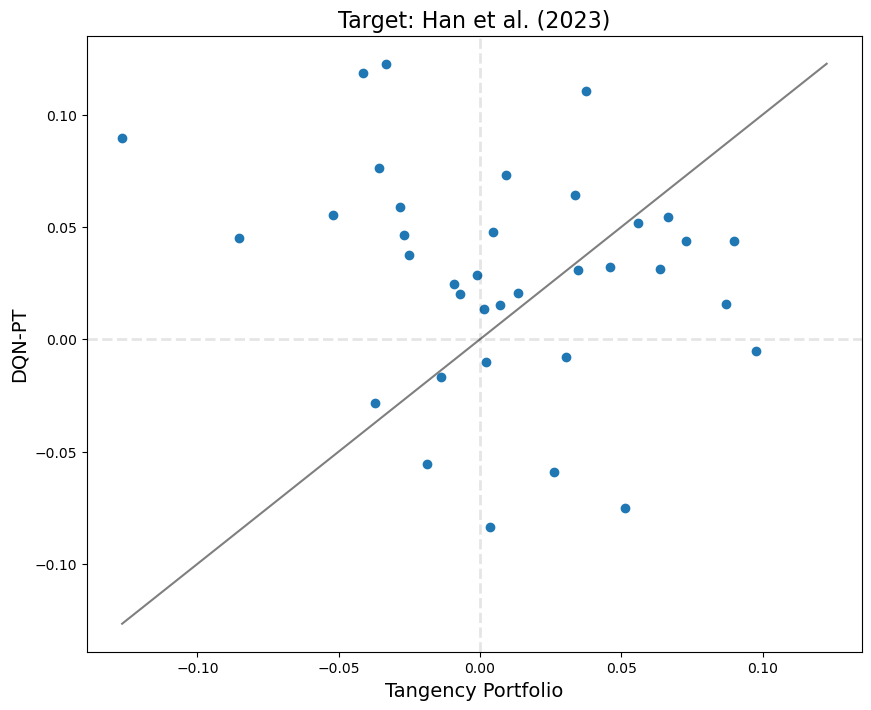

In [101]:
plt.figure(figsize=(10, 8))
plt.scatter(paper_reward_result, dqn_pt_reward)
plt.plot(
    np.linspace(
        min(min(paper_reward_result), min(dqn_pt_reward)),
        max(max(paper_reward_result), max(dqn_pt_reward)),
        200,
    ),
    np.linspace(
        min(min(paper_reward_result), min(dqn_pt_reward)),
        max(max(paper_reward_result), max(dqn_pt_reward)),
        200,
    ),
    color="black",
    alpha=0.5,
)
plt.axhline(y=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.axvline(x=0, color="black", linestyle="--", linewidth=2, alpha=0.1)
plt.xlabel("Tangency Portfolio", fontsize=14)
plt.ylabel("DQN-PT", fontsize=14)
plt.title("Target: Han et al. (2023)", fontsize=16)
plt.savefig(f"{path}/paper_vs_DQNPT_WRS.png", dpi=300, bbox_inches="tight")
plt.show()

## Reward Plot / Cumulative Reward Plot

In [102]:
static_pt_mean = static_pt_table.mean(axis=0)
single_mean_reduced_BandH = single_result_reduced_BandH_table.mean(axis=0)
single_mean_reduced_BB = single_result_reduced_BB_table.mean(axis=0)
single_mean_total_BandH = single_result_total_BandH_table.mean(axis=0)
single_mean_total_BB = single_result_total_BB_table.mean(axis=0)
portfolio_result_reduced_BandH = np.array(portfolio_result_reduced_BandH)
portfolio_result_total_BandH = np.array(portfolio_result_total_BandH)
paper_reward_result = np.array(paper_reward_result)

dqn_pt_cum_reward = []

for i in range(len(dqn_pt_reward)):
    dqn_pt_cum_reward.append(sum(dqn_pt_reward[: i + 1]))

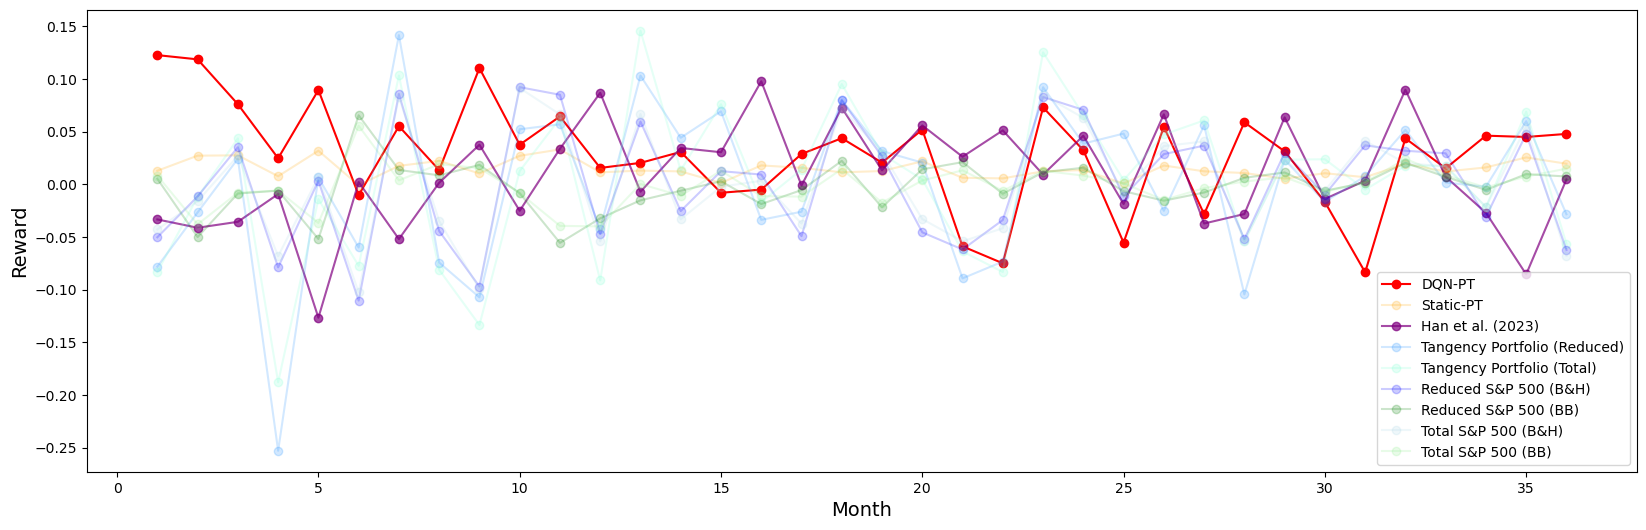

In [123]:
plt.figure(figsize=(20, 6))
plt.plot(range(1, 37), dqn_pt_reward, label="DQN-PT", color="red", marker="o")
plt.plot(
    range(1, 37),
    static_pt_mean,
    label="Static-PT",
    color="orange",
    alpha=0.2,
    marker="o",
)
plt.plot(
    range(1, 37),
    paper_reward_result,
    label="Han et al. (2023)",
    color="purple",
    marker="o",
    alpha=0.7,
)
plt.plot(
    range(1, 37),
    portfolio_result_reduced_BandH,
    label="Tangency Portfolio (Reduced)",
    color="dodgerblue",
    alpha=0.2,
    marker="o",
)
plt.plot(
    range(1, 37),
    portfolio_result_total_BandH,
    label="Tangency Portfolio (Total)",
    color="aquamarine",
    alpha=0.2,
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_reduced_BandH,
    label="Reduced S&P 500 (B&H)",
    color="blue",
    alpha=0.2,
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_reduced_BB,
    label="Reduced S&P 500 (BB)",
    color="green",
    alpha=0.2,
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_total_BandH,
    label="Total S&P 500 (B&H)",
    color="lightblue",
    alpha=0.2,
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_total_BB,
    label="Total S&P 500 (BB)",
    color="lightgreen",
    alpha=0.2,
    marker="o",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.legend(fontsize=10)
plt.savefig(f"{path}/reward_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

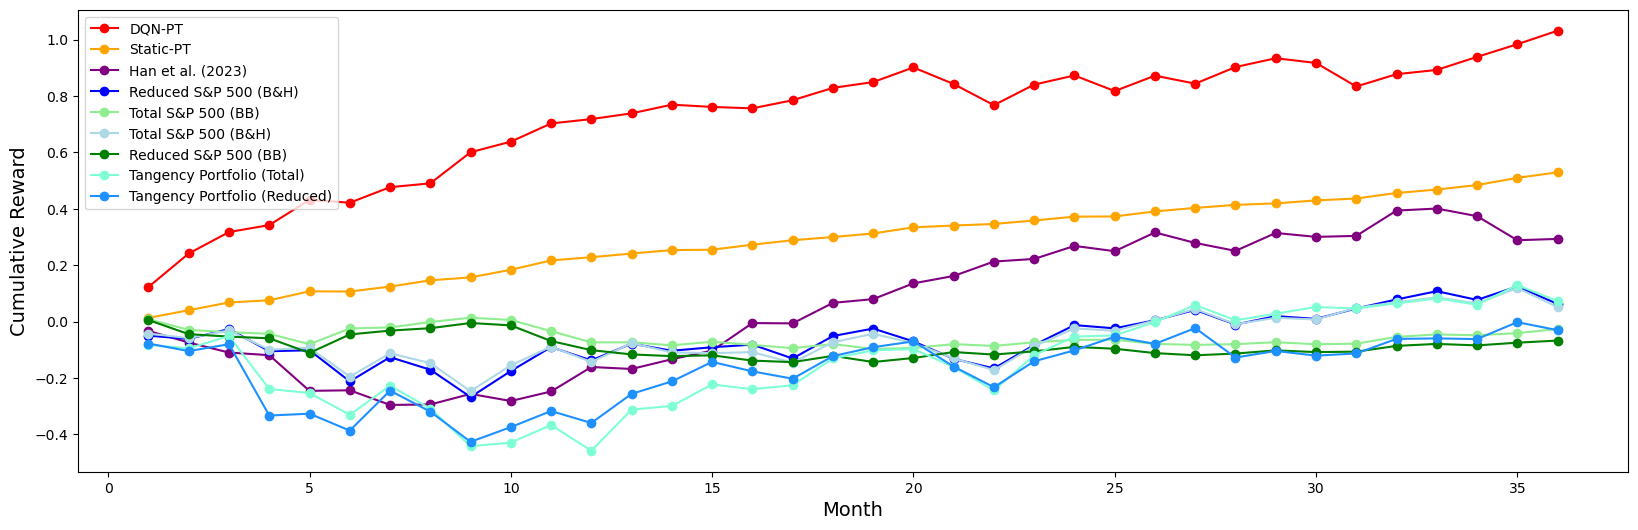

In [124]:
plt.figure(figsize=(20, 6))
plt.plot(range(1, 37), dqn_pt_cum_reward, label="DQN-PT", color="red", marker="o")
plt.plot(
    range(1, 37),
    static_pt_mean.values.cumsum(),
    label="Static-PT",
    color="orange",
    marker="o",
)
plt.plot(
    range(1, 37),
    paper_reward_result.cumsum(),
    label="Han et al. (2023)",
    color="purple",
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_reduced_BandH.cumsum(),
    label="Reduced S&P 500 (B&H)",
    color="blue",
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_total_BB.cumsum(),
    label="Total S&P 500 (BB)",
    color="lightgreen",
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_total_BandH.cumsum(),
    label="Total S&P 500 (B&H)",
    color="lightblue",
    marker="o",
)
plt.plot(
    range(1, 37),
    single_mean_reduced_BB.cumsum(),
    label="Reduced S&P 500 (BB)",
    color="green",
    marker="o",
)
plt.plot(
    range(1, 37),
    portfolio_result_total_BandH.cumsum(),
    label="Tangency Portfolio (Total)",
    color="aquamarine",
    marker="o",
)
plt.plot(
    range(1, 37),
    portfolio_result_reduced_BandH.cumsum(),
    label="Tangency Portfolio (Reduced)",
    color="dodgerblue",
    marker="o",
)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Cumulative Reward", fontsize=14)
plt.legend(fontsize=10)
plt.savefig(f"{path}/cum_reward_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [109]:
print(f"DQN-PT: {np.trapz(dqn_pt_cum_reward, dx=1): .4f}")
print(f"Static-PT: {np.trapz(static_pt_mean.cumsum(), dx=1): .4f}")
print(f"Han et al. (2023): {np.trapz(paper_reward_result.cumsum(), dx=1): .4f}")
print(
    f"Tangency Portfolio (Reduced): {np.trapz(portfolio_result_reduced_BandH.cumsum(), dx=1): .4f}"
)
print(
    f"Tangency Portfolio (Total): {np.trapz(portfolio_result_total_BandH.cumsum(), dx=1): .4f}"
)
print(
    f"Reduced S&P 500 (B&H): {np.trapz(single_mean_reduced_BandH.cumsum(), dx=1): .4f}"
)
print(f"Reduced S&P 500 (BB): {np.trapz(single_mean_reduced_BB.cumsum(), dx=1): .4f}")
print(f"Total S&P 500 (B&H): {np.trapz(single_mean_total_BandH.cumsum(), dx=1): .4f}")
print(f"Total S&P 500 (BB): {np.trapz(single_mean_total_BB.cumsum(), dx=1): .4f}")

DQN-PT:  25.4857
Static-PT:  10.1798
Han et al. (2023):  1.9948
Tangency Portfolio (Reduced): -6.0531
Tangency Portfolio (Total): -4.9483
Reduced S&P 500 (B&H): -2.0274
Reduced S&P 500 (BB): -3.1359
Total S&P 500 (B&H): -2.1204
Total S&P 500 (BB): -2.0512


## Performance Indicators

In [113]:
print(f"Mean Return: {mean_return(dqn_pt_reward) * 100: .3f}")
print(f"Sharpe Ratio: {sharpe_ratio(dqn_pt_reward): .3f}")
print(f"Sortino Ratio: {sortino_ratio(dqn_pt_reward): .3f}")
print(f"Profit Factor: {profit_factor(dqn_pt_reward): .3f}")
print(f"Calmar Ratio: {calmar_ratio(dqn_pt_reward): .3f}")
print(f"Max Drawdown: {max_drawdown(dqn_pt_reward): .3f}")

Mean Return:  34.389
Sharpe Ratio:  2.040
Sortino Ratio:  3.443
Profit Factor:  4.024
Calmar Ratio:  2.657
Max Drawdown: -0.129


In [114]:
print(f"Mean Return: {mean_return(paper_reward_result) * 100: .3f}")
print(f"Sharpe Ratio: {sharpe_ratio(paper_reward_result): .3f}")
print(f"Sortino Ratio: {sortino_ratio(paper_reward_result): .3f}")
print(f"Profit Factor: {profit_factor(paper_reward_result): .3f}")
print(f"Calmar Ratio: {calmar_ratio(paper_reward_result): .3f}")
print(f"Max Drawdown: {max_drawdown(paper_reward_result): .3f}")

Mean Return:  9.768
Sharpe Ratio:  0.582
Sortino Ratio:  0.899
Profit Factor:  1.541
Calmar Ratio:  0.407
Max Drawdown: -0.240


In [115]:
print(
    f"Mean Return: {np.mean([mean_return(static_pt_table.iloc[x, :]) for x in range(len(static_pt_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(static_pt_table.iloc[x, :]) for x in range(len(static_pt_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(static_pt_table.iloc[x, :]) for x in range(len(static_pt_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(static_pt_table.iloc[x, :]) for x in range(len(static_pt_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(static_pt_table.iloc[x, :]) for x in range(len(static_pt_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(static_pt_table.iloc[x, :]) for x in range(len(static_pt_table))]): .3f}"
)

Mean Return:  17.642
Sharpe Ratio:  1.306
Sortino Ratio:  2.643
Profit Factor:  3.006
Calmar Ratio:  1.943
Max Drawdown: -0.125


In [116]:
print(f"Mean Return: {mean_return(portfolio_result_reduced_BandH) * 100: .3f}")
print(f"Sharpe Ratio: {sharpe_ratio(portfolio_result_reduced_BandH): .3f}")
print(f"Sortino Ratio: {sortino_ratio(portfolio_result_reduced_BandH): .3f}")
print(f"Profit Factor: {profit_factor(portfolio_result_reduced_BandH): .3f}")
print(f"Calmar Ratio: {calmar_ratio(portfolio_result_reduced_BandH): .3f}")
print(f"Max Drawdown: {max_drawdown(portfolio_result_reduced_BandH): .3f}")

Mean Return: -1.023
Sharpe Ratio: -0.040
Sortino Ratio: -0.051
Profit Factor:  0.971
Calmar Ratio: -0.031
Max Drawdown: -0.335


In [117]:
print(f"Mean Return: {mean_return(portfolio_result_total_BandH) * 100: .3f}")
print(f"Sharpe Ratio: {sharpe_ratio(portfolio_result_total_BandH): .3f}")
print(f"Sortino Ratio: {sortino_ratio(portfolio_result_total_BandH): .3f}")
print(f"Profit Factor: {profit_factor(portfolio_result_total_BandH): .3f}")
print(f"Calmar Ratio: {calmar_ratio(portfolio_result_total_BandH): .3f}")
print(f"Max Drawdown: {max_drawdown(portfolio_result_total_BandH): .3f}")

Mean Return:  2.415
Sharpe Ratio:  0.097
Sortino Ratio:  0.144
Profit Factor:  1.074
Calmar Ratio:  0.066
Max Drawdown: -0.366


In [118]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_reduced_BB_table.iloc[x, :]) for x in range(len(single_result_reduced_BB_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_reduced_BB_table.iloc[x, :]) for x in range(len(single_result_reduced_BB_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_reduced_BB_table.iloc[x, :]) for x in range(len(single_result_reduced_BB_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_reduced_BB_table.iloc[x, :]) for x in range(len(single_result_reduced_BB_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_reduced_BB_table.iloc[x, :]) for x in range(len(single_result_reduced_BB_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_reduced_BB_table.iloc[x, :]) for x in range(len(single_result_reduced_BB_table))]): .3f}"
)

Mean Return: -2.255
Sharpe Ratio: -0.057
Sortino Ratio: -0.035
Profit Factor:  1.031
Calmar Ratio:  0.042
Max Drawdown: -0.381


In [119]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_total_BB_table.iloc[x, :]) for x in range(len(single_result_total_BB_table))]): .3f}"
)

Mean Return: -0.882
Sharpe Ratio: -0.041
Sortino Ratio:  0.017
Profit Factor:  1.071
Calmar Ratio:  0.112
Max Drawdown: -0.355


In [120]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_reduced_BandH_table.iloc[x, :]) for x in range(len(single_result_reduced_BandH_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_reduced_BandH_table.iloc[x, :]) for x in range(len(single_result_reduced_BandH_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_reduced_BandH_table.iloc[x, :]) for x in range(len(single_result_reduced_BandH_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_reduced_BandH_table.iloc[x, :]) for x in range(len(single_result_reduced_BandH_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_reduced_BandH_table.iloc[x, :]) for x in range(len(single_result_reduced_BandH_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_reduced_BandH_table.iloc[x, :]) for x in range(len(single_result_reduced_BandH_table))]): .3f}"
)

Mean Return:  2.074
Sharpe Ratio:  0.074
Sortino Ratio:  0.140
Profit Factor:  1.123
Calmar Ratio:  0.146
Max Drawdown: -0.371


In [121]:
print(
    f"Mean Return: {np.mean([mean_return(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]) * 100: .3f}"
)
print(
    f"Sharpe Ratio: {np.mean([sharpe_ratio(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Sortino Ratio: {np.mean([sortino_ratio(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Profit Factor: {np.mean([profit_factor(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Calmar Ratio: {np.mean([calmar_ratio(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)
print(
    f"Max Drawdown: {np.mean([max_drawdown(single_result_total_BandH_table.iloc[x, :]) for x in range(len(single_result_total_BandH_table))]): .3f}"
)

Mean Return:  1.705
Sharpe Ratio:  0.085
Sortino Ratio:  0.190
Profit Factor:  1.130
Calmar Ratio:  0.167
Max Drawdown: -0.373
